# Finsler Fréchet Mean

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap, jit
from jax import Array

from abc import ABC

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

import pickle

import os

from load_manifold import load_manifold

from geometry.finsler.geodesics import GEORCE# GEORCE_AdaFM
from geometry.riemannian.manifolds import nEllipsoid, nParaboloid, HyperbolicParaboloid
from geometry.finsler.manifolds import RiemannianNavigation

2025-02-12 18:50:01.234439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [3]:
device = 'gpu'
geometry = "finsler"
batch_size = '10'
path = f'timing_{device}/{geometry}/'
figure_path = '../figures/finsler/frechet/'

In [4]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading Values

In [5]:
def load_manifold_data(manifold:str, dim):
    
    save_path = ''.join((path, manifold, '/'))
    
    onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
    onlyfiles = [f for f in onlyfiles if f'batch={batch_size}.pkl' in f]
    
    estimates = {}
    for file in onlyfiles:
        file_path = ''.join((save_path, file))
        with open(file_path, 'rb') as f:
            values = pickle.load(f)
        method = file.split(f'_{manifold}')[0]
        dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_batch={batch_size}', '')
        if dim in estimates:
            estimates[dim] = dict(estimates[dim], **values)
        else:
            estimates[dim] = values
            
    return estimates
    

## Functions

In [6]:
def force_fun(z, M):
    
    val = jnp.cos(z)
    
    val2 = jnp.sqrt(jnp.einsum('i,ij,j->', val, M.G(z), val))
    
    return jnp.sin(z)*val/val2
    
v0 = 1.5

## Loading Estimates and Data

In [7]:
ellipsoid_method = load_manifold_data("Ellipsoid", dim=2)['2']
sphere_method = load_manifold_data("Sphere", dim=2)['2']
paraboloid_method = load_manifold_data("Paraboloid", 2)['2']
hyppar_method = load_manifold_data("HyperbolicParaboloid", 2)['2']

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [8]:
ellipsoid_data, M_ellipsoid, *_ = load_manifold("Ellipsoid", dim=2, N_data=100)
sphere_data, M_sphere, *_ = load_manifold("Sphere", dim=2, N_data=100)
paraboloid_data, M_paraboloid, *_ = load_manifold("Paraboloid", dim=2, N_data=100)
hyppar_data, M_hyppar, *_ = load_manifold("HyperbolicParaboloid", dim=2, N_data=100)

In [9]:
sphere_geodesics = vmap(vmap(M_sphere.f))(sphere_method['GEORCE_FM']['zt'])
ellipsoid_geodesics = vmap(vmap(M_ellipsoid.f))(ellipsoid_method['GEORCE_FM']['zt'])
paraboloid_geodesics = vmap(vmap(M_paraboloid.f))(paraboloid_method['GEORCE_FM']['zt'])
hyppar_geodesics = vmap(vmap(M_hyppar.f))(hyppar_method['GEORCE_FM']['zt'])

## Plotting the Frechet Mean

In [10]:
class EllipsoidPlot(ABC):
    def __init__(self, 
                 params=jnp.linspace(0.5,1.0,3),
                ):
        
        self.M = nEllipsoid(dim=2, params=params)
        self.force_fun = lambda z: force_fun(z, self.M)
        self.params = params

    def heat_map(self, X, Y, Z)->Array:
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        heat_map = vmap(lambda z1: vmap(lambda z: jnp.linalg.norm(self.force_fun(z)))(z1))(z)
        
        return heat_map
    
    def unit_direction(self, n_points:int=100)->Array:
        
        X,Y,Z = self.grid(n_points)
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        force = vmap(lambda z1: vmap(lambda z: jnp.dot(self.M.Jf(z), self.force_fun(z)))(z1))(z)
        
        return X,Y,Z,force
        
    def grid(self, n_points:int=100)->Array:
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

In [11]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        self.M = nParaboloid(dim=2)
        self.force_fun = lambda z: force_fun(z, self.M)
        
        return
    
    def heat_map(self, n_points:int=100)->Array:
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        heat_map = vmap(lambda u1,v1: \
                        vmap(lambda u,v: \
                             jnp.linalg.norm(self.force_fun(jnp.stack((u,v)))))(u1,v1))(X1,X2)
        
        return heat_map
    
    def unit_direction(self, n_points:int=100)->Array:
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        force = vmap(lambda u1,v1: \
                     vmap(lambda u,v: jnp.dot(self.M.Jf(jnp.stack((u,v))),
                                              self.force_fun(jnp.stack((u,v)))))(u1,v1))(X1,X2)
        
        return X1, X2, X1**2+X2**2, force

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2

In [12]:
class HyperbolicParaboloidPlot(ABC):
    def __init__(self):
        
        self.M = HyperbolicParaboloid()
        self.force_fun = lambda z: force_fun(z, self.M)
        
        return
    
    def heat_map(self, n_points:int=100)->Array:
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        heat_map = vmap(lambda u1,v1: \
                        vmap(lambda u,v: \
                             jnp.linalg.norm(self.force_fun(jnp.stack((u,v)))))(u1,v1))(X1,X2)
        
        return heat_map
    
    def unit_direction(self, n_points:int=100)->Array:
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        force = vmap(lambda u1,v1: \
                     vmap(lambda u,v: jnp.dot(self.M.Jf(jnp.stack((u,v))),
                                              self.force_fun(jnp.stack((u,v)))))(u1,v1))(X1,X2)
        
        return X1, X2, X1**2-X2**2, force

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2-X2**2

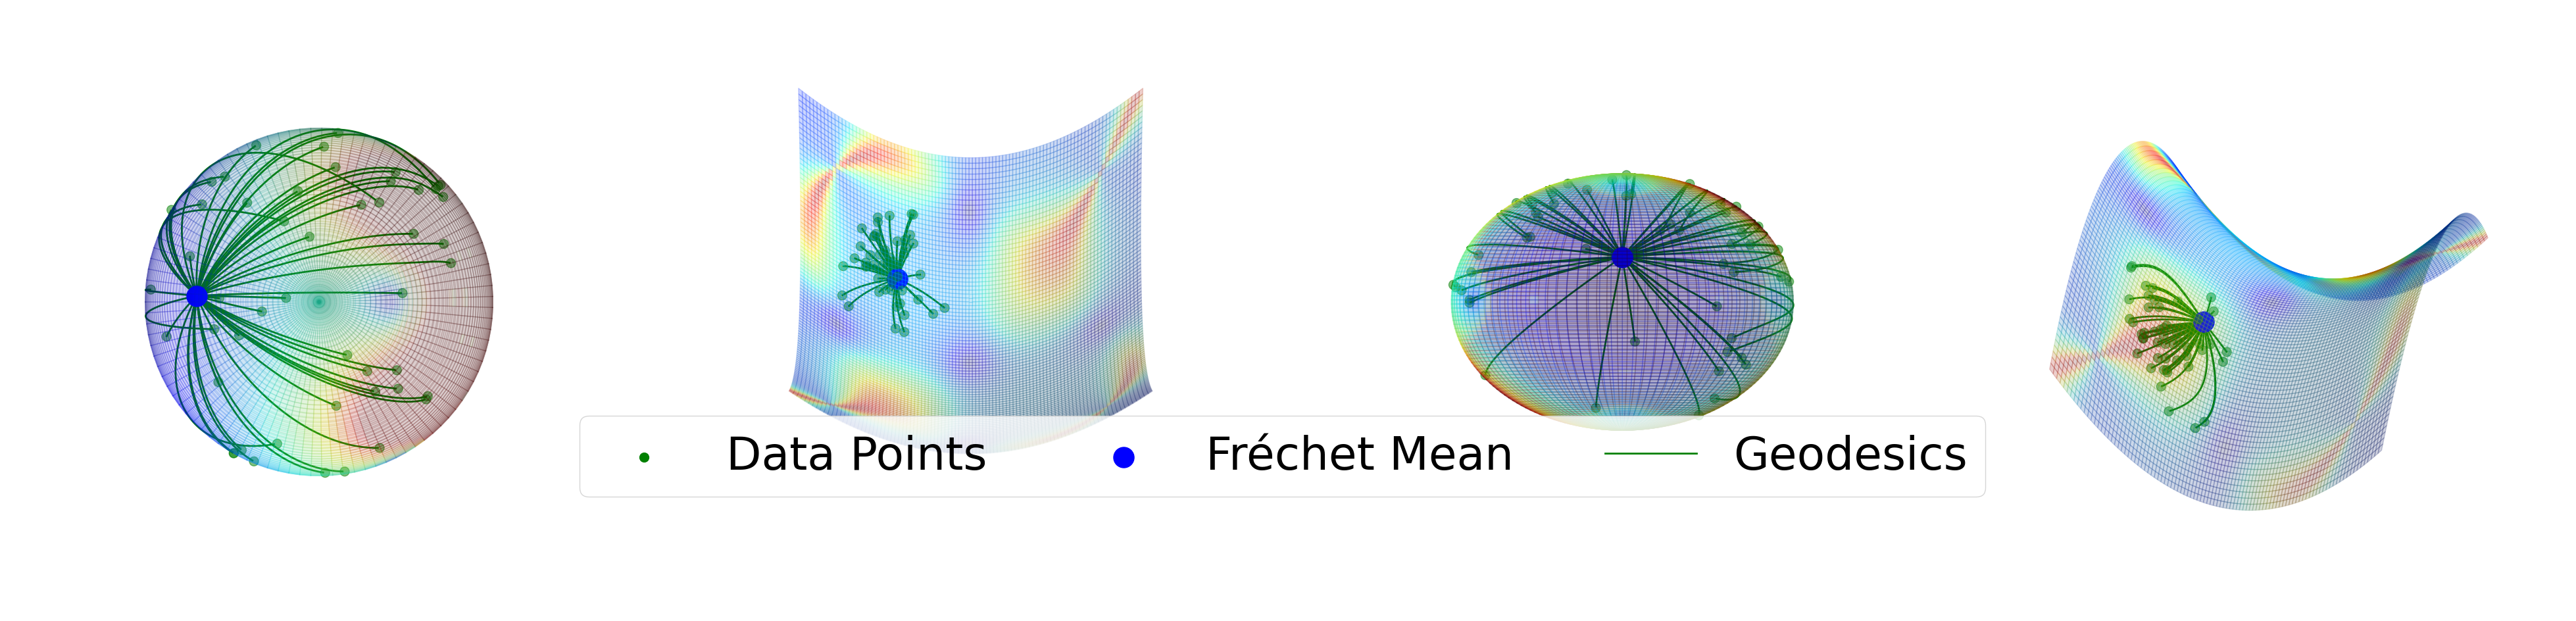

In [13]:
fig = plt.figure(figsize=(40,10))

#plotting sphere
plot_sphere = EllipsoidPlot(params=jnp.ones(3))
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(x1,x2,x3)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(141, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.1,
               facecolors=plt.cm.jet(heat_map))
#ax.quiver(field[0], field[1], field[2], 
#          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
for geo in sphere_geodesics[::2]:
    ax.plot(geo[:,0],
            geo[:,1],
            geo[:,2],
            alpha=1.0,
            linewidth=2.0,
            color='green',
           )
for key, vals in sphere_method.items():
    if key == "GEORCE_FM":
        mu = M_sphere.f(vals['mu'])
        ax.scatter(mu[0],
                   mu[1],
                   mu[2],
                   s=500,
                   color='blue'
                  )    
obs = vmap(M_sphere.f)(sphere_data)[::2]
ax.scatter(obs[:,0], obs[:,1], obs[:,2], color='green', alpha=0.5, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=90., azim=90)

#plotting paraboloid
plot_sphere = ParaboloidPlot()
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(100)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(142, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
#ax.quiver(field[0], field[1], field[2], 
#          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', alpha=0.2, length=0.2, normalize=True)
for geo in paraboloid_geodesics[::2]:
    ax.plot(geo[:,0],
            geo[:,1],
            geo[:,2],
            alpha=1.0,
            linewidth=2.0,
            color='green',
           )
for key, vals in paraboloid_method.items():
    if key == "GEORCE_FM":
        mu = M_paraboloid.f(vals['mu'])
        ax.scatter(mu[0],
                   mu[1],
                   mu[2],
                   s=500,
                   color='blue'
                  )    
obs = vmap(M_paraboloid.f)(paraboloid_data)[::2]
ax.scatter(obs[:,0], obs[:,1], obs[:,2], color='green', alpha=0.5, s=100)
ax.set_axis_off()
ax.view_init(elev=60., azim=180.)

#plotting Ellipsoid
plot_sphere = EllipsoidPlot()
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(x1,x2,x3)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(143, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
#ax.quiver(field[0], field[1], field[2], 
#          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', alpha=0.2, length=0.2, normalize=True)
for geo in ellipsoid_geodesics[::2]:
    ax.plot(geo[:,0],
            geo[:,1],
            geo[:,2],
            alpha=1.0,
            linewidth=2.0,
            color='green',
           )
for key, vals in ellipsoid_method.items():
    if key == "GEORCE_FM":
        mu = M_ellipsoid.f(vals['mu'])
        ax.scatter(mu[0],
                   mu[1],
                   mu[2],
                   s=500,
                   color='blue'
                  )    
obs = vmap(M_ellipsoid.f)(ellipsoid_data)[::2]
ax.scatter(obs[:,0], obs[:,1], obs[:,2], color='green', alpha=0.5, s=100)
ax.set_axis_off()
ax.view_init(elev=180., azim=180)

#plotting paraboloid
plot_sphere = HyperbolicParaboloidPlot()
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(100)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(144, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
#ax.quiver(field[0], field[1], field[2], 
#          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
for geo in hyppar_geodesics[::2]:
    ax.plot(geo[:,0],
            geo[:,1],
            geo[:,2],
            alpha=1.0,
            linewidth=2.0,
            color='green',
           )
for key, vals in hyppar_method.items():
    if key == "GEORCE_FM":
        mu = M_hyppar.f(vals['mu'])
        ax.scatter(mu[0],
                   mu[1],
                   mu[2],
                   s=500,
                   color='blue',
                  )    
obs = vmap(M_hyppar.f)(hyppar_data)[::2]
ax.scatter(obs[:,0], obs[:,1], obs[:,2], color='green', alpha=0.5, s=100)
ax.set_axis_off()
ax.view_init(elev=40., azim=110.)

ax.scatter([],[],[], color="green", alpha=1.0, s=100, label="Data Points")
ax.scatter([],[],[], color="blue", alpha=1.0, s=500, label="Fréchet Mean")
ax.plot([],[],[], color="green", alpha=1.0, linewidth=2.0, label=r"Geodesics")

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.225, 0.2), ncol=3, fontsize=50)

fig.tight_layout()

save_path = f'{figure_path}finsler_frechet.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

